In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

D:\GG_env\llm_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [3]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# KV Caching

In [4]:
prompt = "The quick brown fox jumped over the"

In [5]:
inputs = tokenizer(prompt, return_tensors='pt')
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [6]:
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
logits

tensor([[[ -36.2874,  -35.0114,  -38.0793,  ...,  -40.5163,  -41.3760,
           -34.9193],
         [ -62.3139,  -61.5645,  -66.4938,  ...,  -68.1286,  -68.3227,
           -63.5829],
         [ -66.3240,  -66.7452,  -72.1618,  ...,  -75.1955,  -73.4651,
           -68.1786],
         ...,
         [-128.5381, -132.0339, -138.6297,  ..., -143.2243, -139.4765,
          -134.6457],
         [ -79.0953,  -81.2003,  -86.2657,  ...,  -90.5052,  -87.8185,
           -83.2593],
         [ -92.9353,  -92.3160,  -96.0634,  ...,  -95.3960,  -96.1433,
           -94.6932]]])

In [7]:
logits.shape

torch.Size([1, 7, 50257])

In [8]:
last_logits = logits[0, -1, :]
last_logits, len(last_logits)

(tensor([-92.9353, -92.3160, -96.0634,  ..., -95.3960, -96.1433, -94.6932]),
 50257)

In [9]:
next_token_id = last_logits.argmax()
next_token_id

tensor(13990)

In [10]:
tokenizer.decode(next_token_id)

' fence'

In [11]:
top_k = torch.topk(last_logits, k=10)
top_k

torch.return_types.topk(
values=tensor([-81.8955, -82.3976, -82.9707, -83.0715, -83.2480, -83.5198, -83.5478,
        -83.8078, -83.8791, -83.8842]),
indices=tensor([13990,  5743, 47590,  3355,  3084,  5509,  1353,  3753,  2323,  1735]))

In [12]:
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' fence',
 ' edge',
 ' railing',
 ' wall',
 ' table',
 ' tree',
 ' top',
 ' counter',
 ' ground',
 ' side']

In [13]:
next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    ),
}

In [14]:
next_inputs["input_ids"], next_inputs["input_ids"].shape

(tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]]),
 torch.Size([1, 8]))

In [15]:
next_inputs["attention_mask"], next_inputs["attention_mask"].shape

(tensor([[1, 1, 1, 1, 1, 1, 1, 1]]), torch.Size([1, 8]))

## without KV Cache

In [16]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

In [17]:
generated_tokens = []
next_inputs = inputs
durations_s = []

for _ in range(10):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]

    next_inputs = { 
        "input_ids": torch.cat(
            [inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1
            ),
        "attention_mask": torch.cat(
            [inputs["attention_mask"], torch.tensor([[1]])],
            dim=1
            ),
        }
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"소요시간: {sum(durations_s)}")
print(generated_tokens)

소요시간: 0.8474619388580322
[' fence', ' and', ' ran', ' of', ' the', ' fence', ' and', ' ran', ' of', ' the']


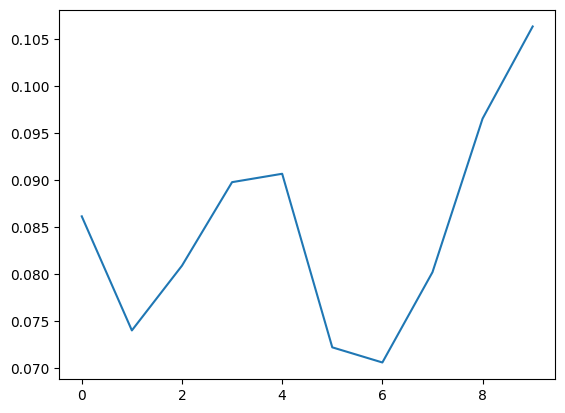

In [18]:
plt.plot(durations_s)
plt.show()

## with KV Cache

In [19]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [20]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []

for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]

    next_inputs = { 
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values,
        }
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"소요시간: {sum(durations_cached_s)}")
print(generated_tokens)

소요시간: 0.7301609516143799
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


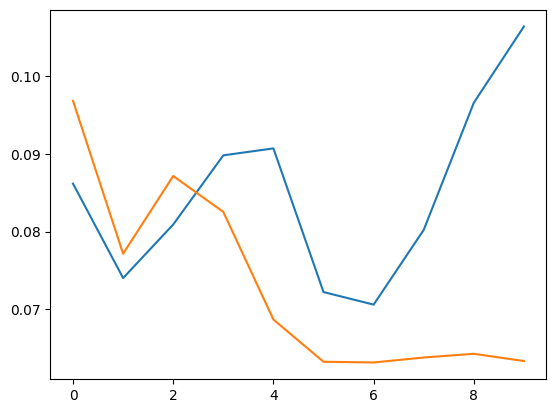

In [21]:
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()

# Batching - issues with multiple inputs

## Single Input

In [22]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors='pt')

def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = generate_token_with_past(next_inputs)
    
        next_inputs = { 
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1),
            "past_key_values": past_key_values,
            }
        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens)
    
tokens = generate(inputs, max_tokens=10)
tokens

' fence and ran to the other side of the fence'

## Multiple inputs

In [23]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

In [24]:
# Pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_siede = "left"

In [25]:
# mutiple prompts of varying lengths to send to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must"
]
# note: padding=True ensures the padding tokens
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])}

In [26]:
inputs["input_ids"].shape

torch.Size([3, 7])

In [27]:
# position_ids tell the transformer the ordinal position of each token in the input sequence
# for single input inference, this is just [0, ..n]
# for n tokens, but for batch inference, 
# we need to 0 out the padding tokens at the start of the sequence

attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1  # 모든항에서 1씩 빼고
print(position_ids)
position_ids.masked_fill_(attention_mask == 0, 1)  # 어텐션마스크가 0인 곳은 1로 변경

tensor([[ 0,  1,  2,  3,  4,  5,  6],
        [-1, -1,  0,  1,  2,  3,  4],
        [-1, -1, -1,  0,  1,  2,  3]])


tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

In [28]:
# same as before, but include the position_ids
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits
logits

tensor([[[ -36.2874,  -35.0114,  -38.0793,  ...,  -40.5163,  -41.3760,
           -34.9193],
         [ -62.3139,  -61.5645,  -66.4938,  ...,  -68.1286,  -68.3227,
           -63.5829],
         [ -66.3240,  -66.7452,  -72.1618,  ...,  -75.1955,  -73.4651,
           -68.1786],
         ...,
         [-128.5381, -132.0339, -138.6297,  ..., -143.2243, -139.4765,
          -134.6457],
         [ -79.0953,  -81.2003,  -86.2657,  ...,  -90.5052,  -87.8185,
           -83.2593],
         [ -92.9353,  -92.3160,  -96.0634,  ...,  -95.3960,  -96.1433,
           -94.6932]],

        [[ -82.9563,  -81.2288,  -85.6027,  ...,  -90.0016,  -87.0977,
           -81.3762],
         [ -79.6378,  -77.1435,  -80.7339,  ...,  -88.2952,  -85.1466,
           -78.3022],
         [ -36.2874,  -35.0114,  -38.0793,  ...,  -40.5163,  -41.3760,
           -34.9193],
         ...,
         [ -83.7137,  -83.1081,  -86.4281,  ...,  -89.6049,  -90.0962,
           -85.0687],
         [-107.7989, -107.0251, -112.746

In [29]:
last_logits = logits[:, -1, :]
last_logits

tensor([[ -92.9353,  -92.3160,  -96.0634,  ...,  -95.3960,  -96.1433,
          -94.6932],
        [-134.3496, -134.5265, -141.9093,  ..., -143.6232, -143.3913,
         -136.7095],
        [ -69.8395,  -70.2566,  -75.9295,  ...,  -77.3883,  -79.3200,
          -73.0099]])

In [30]:
next_token_ids = last_logits.argmax(dim=1)
next_token_ids

tensor([13990,   319,   307])

In [31]:
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

[' fence', ' on', ' be']

In [32]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

In [33]:
def generate_batch(inputs, max_tokens):
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
        }
    
    for _ in range(max_tokens):
        next_token_ids, past_key_values = generate_batch_tokens_with_past(next_inputs)
    
        next_inputs = { 
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:,-1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"], 
                torch.ones((next_token_ids.shape[0], 1))
            ], dim=1),
            "past_key_values": past_key_values,
            }
        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [34]:
generated_tokens = generate_batch(inputs, max_tokens=10)
generated_tokens

[' fence and ran to the other side of the fence',
 ' on the first day of the month, and the',
 ' be a good idea.\n\n"I think']

In [35]:
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



## Throughput vs. Latency

In [36]:
# contants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

In [37]:
batch_sizes = [2**p for p in range(8)]
batch_sizes

[1, 2, 4, 8, 16, 32, 64, 128]

In [38]:
for batch_size in batch_sizes:
    print(f"bs: {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print(f"ntokens: {ntokens}")
    print(f"duration_s: {duration_s}")
    print(f"throughput: {throughput}")
    print(f"avg_latency: {avg_latency}")
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs: 1
ntokens: 10
duration_s: 0.702742338180542
throughput: 14.229966598982532
avg_latency: 0.0702742338180542

bs: 2
ntokens: 20
duration_s: 0.6892168521881104
throughput: 29.018443087258305
avg_latency: 0.06892168521881104

bs: 4
ntokens: 40
duration_s: 0.7129073143005371
throughput: 56.10827550457335
avg_latency: 0.07129073143005371

bs: 8
ntokens: 80
duration_s: 0.893730878829956
throughput: 89.51240456717065
avg_latency: 0.08937308788299561

bs: 16
ntokens: 160
duration_s: 1.0521368980407715
throughput: 152.07146550790372
avg_latency: 0.10521368980407715

bs: 32
ntokens: 320
duration_s: 1.4413349628448486
throughput: 222.0164002463362
avg_latency: 0.14413349628448485

bs: 64
ntokens: 640
duration_s: 2.6276538372039795
throughput: 243.56328483549717
avg_latency: 0.2627653837203979

bs: 128
ntokens: 1280
duration_s: 4.67971658706665
throughput: 273.52083746642705
avg_latency: 0.467971658706665



In [39]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color = color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax1.set_xscale('log', base=2)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()
    

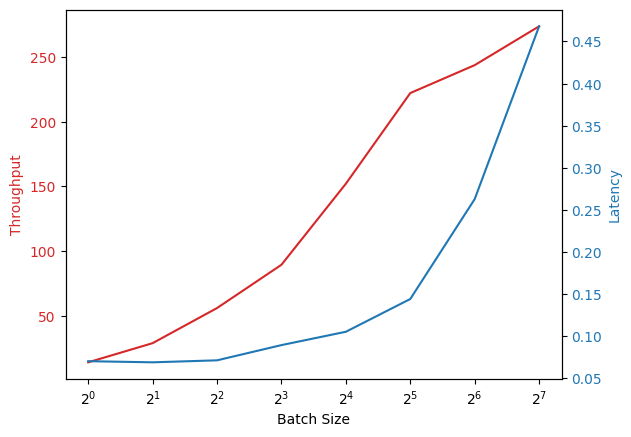

In [40]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)

# Continuous Batching

In [41]:
import copy
import random
import torch.nn.functional as F

In [42]:
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id
tokenizer.padding_side = "left"
tokenizer.truncation_siede = "left"

In [43]:
# mutiple prompts of varying lengths to send to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must"
]

inputs = tokenizer(prompts, padding=True, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])}

In [44]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

In [45]:
def generate_batch(inputs, max_tokens):
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
        }
    
    for _ in range(max_tokens):
        next_token_ids, past_key_values = generate_batch_tokens_with_past(next_inputs)
    
        next_inputs = { 
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:,-1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"], 
                torch.ones((next_token_ids.shape[0], 1))
            ], dim=1),
            "past_key_values": past_key_values,
            }
        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [46]:
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

batches = [
    request_queue[i:i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

In [47]:
request_queue[:8]

[('The quick brown fox jumped over the', 100),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10)]

In [48]:
len(batches)

4

In [49]:
batches[:1]

[[('The quick brown fox jumped over the', 100),
  ('The quick brown fox jumped over the', 10),
  ('The quick brown fox jumped over the', 10),
  ('The quick brown fox jumped over the', 10),
  ('The quick brown fox jumped over the', 10),
  ('The quick brown fox jumped over the', 10),
  ('The quick brown fox jumped over the', 10),
  ('The quick brown fox jumped over the', 10)]]

In [50]:
# generate tokens for all batches and record duration

t0 = time.time()
with tqdm(total=len(batches), desc=f"bs: {batch_size}") as pbar:
    for i, batch in enumerate(batches):
        # to accomplish all the requests with out current implementation, we take the max of all the tokens to generate among the requests
        batch_max_tokens = [b[1] for b in batch]
        max_tokens = max(batch_max_tokens)
        pbar.set_postfix({'max_tokens': max_tokens})

        batch_prompts = [b[0] for b in batch]
        inputs = tokenizer(
            batch_prompts, padding=True, return_tensors="pt")
        generate_batch(inputs, max_tokens=max_tokens)

        pbar.update(1)
duration_s = time.time() - t0
duration_s

bs: 8: 100%|████████████| 4/4 [00:34<00:00,  8.65s/it, max_tokens=100]


34.622780561447144

## 개선해보기

In [53]:
import helpers
from helpers import init_batch, generate_next_token
from helpers import merge_batches, filter_batches

ImportError: cannot import name 'init_batch' from 'helpers' (D:\GG_env\llm_env\lib\site-packages\helpers\__init__.py)

In [ ]:
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]


t0 = time.time()
with tqdm(total=len(batches), desc=f"bs: {batch_size}") as pbar:
    # first, let's seed the initial cached_batch
    # with the first 'batch_size' input
    # and run the initial prefill step
    batch = init_batch(request_queue[:batch_size])
    cached_batch = generate_next_token(batch)
    request_queue = request_queue[batch_size:]

    # continue until both the request queue is fully drained and every input within the cached_batch has completed generation
    while (
        len(request_queue) > 0 or
        cached_batch['input_ids'].size(0) > 0
    ):
        batch_capacity = (
            batch_size - cached_batch["input_ids"].size(0)
        )
        if batch_capacity > 0 and len(request_queue) > 0:
            # prefill
            new_batch = init_batch(request_queue[:batch_capacity])
            new_batch = generate_next_token(new_batch)
            request_queue = request_queue[batch_capacity:]

            # merge
            cached_batch = merge_batches(cached_batch, new_batch)

        # decode
        cached_batch = generate_next_token(cached_batch)

        # remove any inputs that have finished generation
        cached_batch, removed_indices = filter_batch(cached_batch)
        pbar.update(len(removed_indices))
    
duration_s = time.time() - t0
duration_s